## **패키지 설치 및 라이브러리 구성**

In [1]:
!pip install catboost
!pip install category_encoders

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
#SMOTE 설치
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0

  Using cached scikit_learn-0.23.1-cp38-cp38-manylinux1_x86_64.whl (6.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.0
    Uninstalling scikit-learn-1.1.0:
      Successfully uninstalled scikit-learn-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2021.11.30 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
dask-ml 2021.11.30 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
autokeras 1.0.16.post1 requires keras-tuner<1.1,>=1.0.2, but you have keras-tuner 1.1.0 which is incompatible.
autokeras 1.0.16.post1 requires tensorflow<2.6,>=2.3.0, but you have tensorflow 2.7.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin

In [3]:
pip install scikit-learn  -U

  Using cached scikit_learn-1.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2021.11.30 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
autokeras 1.0.16.post1 requires keras-tuner<1.1,>=1.0.2, but you have keras-tuner 1.1.0 which is incompatible.
autokeras 1.0.16.post1 requires tensorflow<2.6,>=2.3.0, but you have tensorflow 2.7.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

# model import
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, auc, confusion_matrix, roc_auc_score ,roc_curve,auc, f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTENC, SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter

from tqdm.notebook import tqdm
import time

## **데이터 불러오기**

In [5]:
train = pd.read_csv('before_engineering_train.csv')
test = pd.read_csv('before_engineering_test.csv')

In [6]:
y_test = test['credit']
test.drop(columns='credit', axis=1, inplace=True)

## **Feature Engineering**

### **파생변수 생성**
* numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
* category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을 때 가장 logloss가 낮았음

In [7]:
for df in [train,test]:
  # before_EMPLOYED: 고용되기 전까지의 일수
  df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
  df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
  df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
  df['Age'] = df['DAYS_BIRTH'] // 365
  df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
  df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


  #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
  df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
  df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #ability: 소득/(살아온 일수+ 근무일수)
  df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

  #income_mean: 소득/ 가족 수
  df['income_mean'] = df['income_total'] / df['family_size']

  #ID 생성: gender, DAYS_BIRTH, income_total, income_type, edu_type, occyp_type 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
#   df['ID'] = df['gender'].astype(str) + '_' + df['DAYS_BIRTH'].astype(str) + '_' + df['income_total'].astype(str) + '_'  + df['income_type'].astype(str) + '_' + df['edu_type'].astype(str) + '_' + df['occyp_type'].astype(str)
  #  + '_' + df['begin_month'].astype(str)

In [8]:
# train['ID'].value_counts()

<AxesSubplot:>

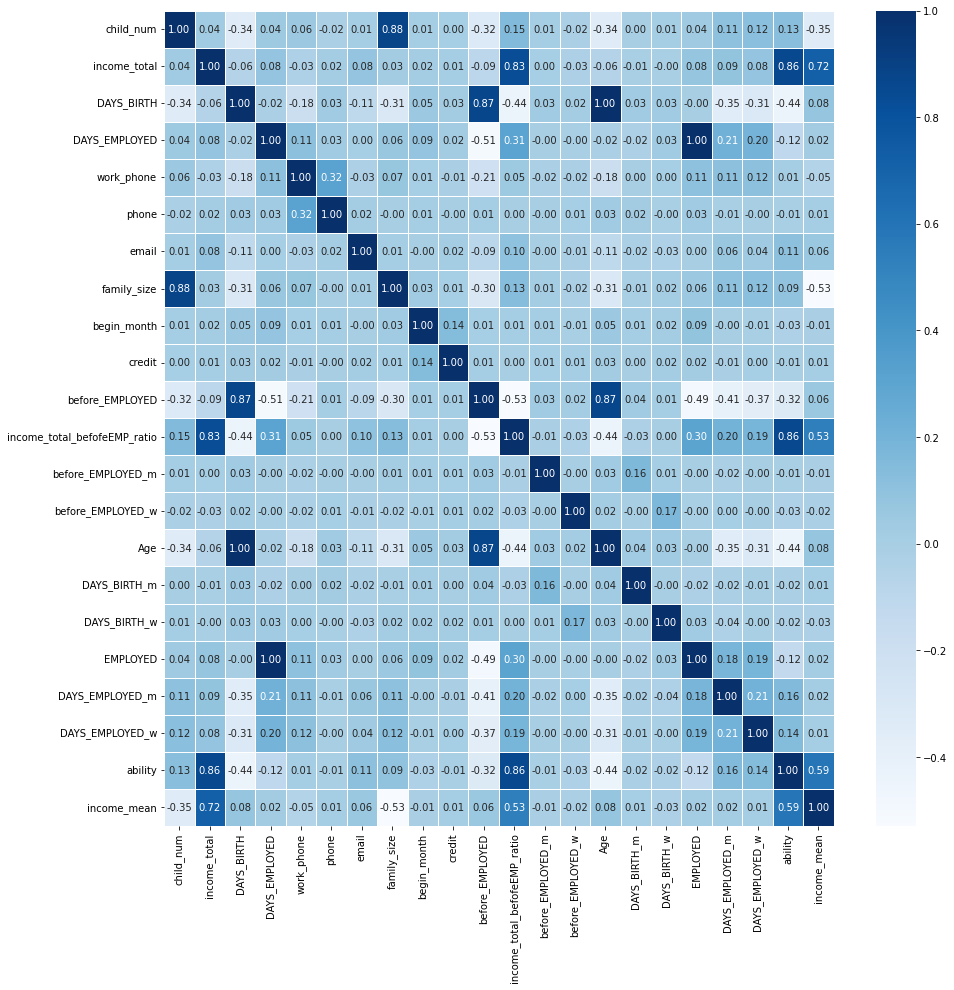

In [9]:
corr = train.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

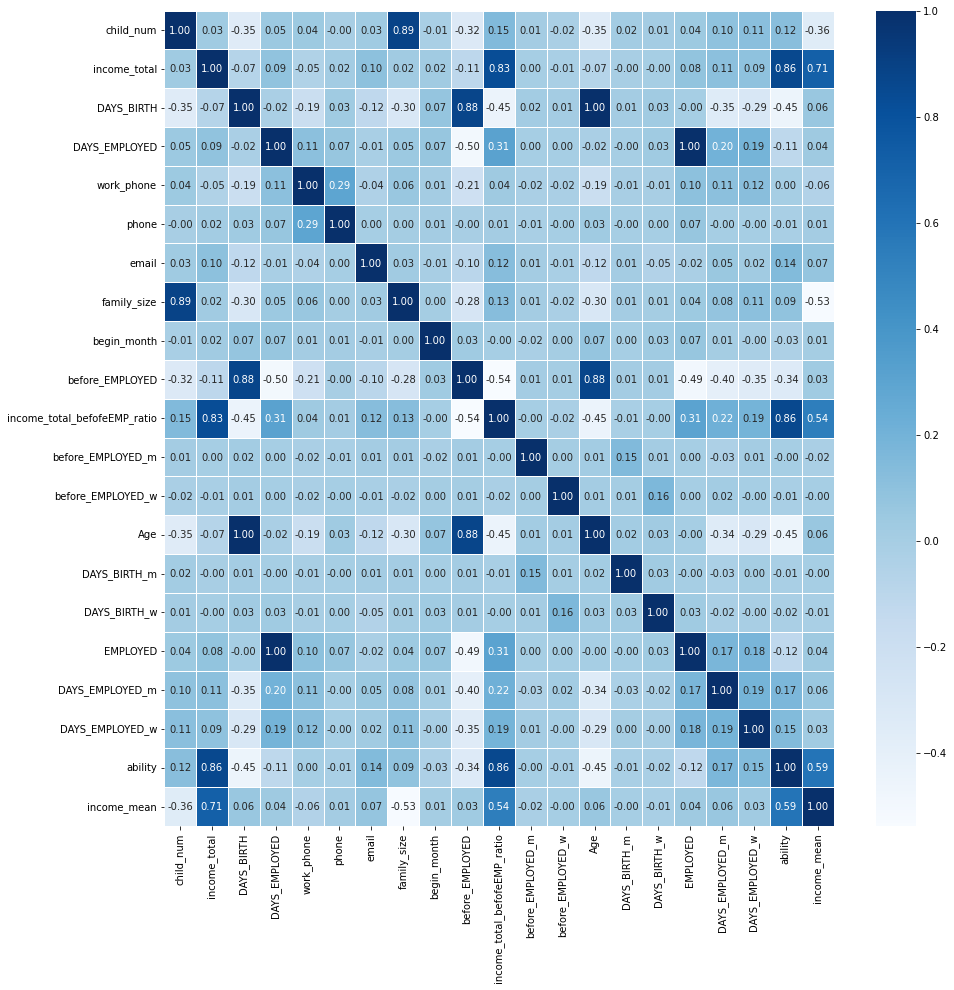

In [10]:
test_corr = test.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=test_corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

### **파생변수와 다중공선을 보이는 컬럼 삭제**

In [11]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
# df.drop(cols, axis=1, inplace=True)
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## **Scaling, Encoding**

### **1. Numerical, Categorical 컬럼 분류**

In [12]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()

numerical_feats.remove('credit')
numerical_feats.remove('work_phone')
numerical_feats.remove('phone')
numerical_feats.remove('email')

print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
# categorical_feats.append('work_phone')
# categorical_feats.append('phone')
# categorical_feats.append('email')
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  15
Number of Categorical features:  11


In [13]:
numerical_feats

['income_total',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [14]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'work_phone',
 'phone',
 'email']

### **2. Log Scaling**

*   income_total



In [15]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### **3. Standard Scaling**

* 이미 로그스케일링을 진행한 income_total을 제외한 나머지 수치형 컬럼 정규화

In [16]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

### **4. One-hot Encoding**

In [17]:
train = pd.get_dummies(train, columns = categorical_feats)
test = pd.get_dummies(test, columns = categorical_feats)

## **Over Sampling**

* target이 imbalanced하기에 오버 샘플링 진행
* SMOTE, BoderlineSMOTE, ADASYN 적용 결과 SMOTE가 가장 성능이 좋아서 SMOTE 채택

In [18]:
X_train = train.drop(labels=['credit'], axis=1)
y_train = train['credit']

In [19]:
# pd.set_option('display.max_seq_items', 10)

In [20]:
X_train.columns

Index(['income_total', 'family_size', 'begin_month', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED',
       'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean',
       'gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N', 'reality_Y',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'edu_type_Academic degree',
       'edu_type_Higher education', 'edu_type_Incomplete higher',
       'edu_type_Lower secondary', 'edu_type_Secondary / secondary special',
       'family_type_Civil marriage', 'family_type_Married',
       'family_type_Separated', 'family_type_Single / not married',
       'family_type_Widow', 'house_type_Co-op apartment',
       'house_type_House / apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented

In [21]:
categorical = ['gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N', 'reality_Y',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'edu_type_Academic degree',
       'edu_type_Higher education', 'edu_type_Incomplete higher',
       'edu_type_Lower secondary', 'edu_type_Secondary / secondary special',
       'family_type_Civil marriage', 'family_type_Married',
       'family_type_Separated', 'family_type_Single / not married',
       'family_type_Widow', 'house_type_Co-op apartment',
       'house_type_House / apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented apartment',
       'house_type_With parents', 'occyp_type_Accountants',
       'occyp_type_Cleaning staff', 'occyp_type_Cooking staff',
       'occyp_type_Core staff', 'occyp_type_Drivers', 'occyp_type_HR staff',
       'occyp_type_High skill tech staff', 'occyp_type_IT staff',
       'occyp_type_Laborers', 'occyp_type_Low-skill Laborers',
       'occyp_type_Managers', 'occyp_type_Medicine staff',
       'occyp_type_Private service staff', 'occyp_type_Realty agents',
       'occyp_type_Sales staff', 'occyp_type_Secretaries',
       'occyp_type_Security staff', 'occyp_type_Waiters/barmen staff',
       'occyp_type_unknown', 'work_phone_0', 'work_phone_1', 'phone_0',
       'phone_1', 'email_0', 'email_1']

In [22]:
categorical_indexes = []
for c in categorical:
    categorical_indexes.append(X_train.columns.get_loc(c))
categorical_indexes

[15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66]

In [23]:
# SMOTENC 모델 설정
smotenc = SMOTENC(categorical_features= categorical_indexes,random_state = 42, k_neighbors= 5)
X_train_res, y_train_res = smotenc.fit_resample(X_train, y_train)

print('Before Resampled dataset shape %s' % Counter(y_train))
print('After Resampled dataset shape %s' % Counter(y_train_res))

Before Resampled dataset shape Counter({2.0: 11028, 1.0: 4171, 0.0: 2172})
After Resampled dataset shape Counter({2.0: 11028, 1.0: 11028, 0.0: 11028})


In [24]:
y_train.value_counts()

2.0    11028
1.0     4171
0.0     2172
Name: credit, dtype: int64

In [25]:
y_train_res.value_counts()

2.0    11028
1.0    11028
0.0    11028
Name: credit, dtype: int64

## **Model - CatboostClassifier**

* fold 수를 5부터 17까지 돌려보고 최적 fold 5로 판단 후 선택



In [26]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

target = 'credit'
X = X_train_res
y = y_train_res
X_test = test

In [27]:
from sklearn.metrics import classification_report

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], 1))
cat_pred_test = np.zeros((X_test.shape[0], 1))

cat_pred_proba = np.zeros((X.shape[0], n_class))
cat_pred_proba_test = np.zeros((X_test.shape[0], n_class))


# cat_cols = ['income_type','edu_type','family_type','house_type', 'occyp_type']
for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
#   train_data = Pool(data=X_train, label=y_train, cat_features=categorical)
#   valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical)

  train_data = Pool(data=X_train, label=y_train)
  valid_data = Pool(data=X_valid, label=y_valid)

  model_cat = CatBoostClassifier(n_estimators=n_est, random_seed=seed, bootstrap_type ='Bernoulli')
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict(X_valid)

  cat_pred_proba[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_proba_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred_proba[valid_idx]):.6f}')
  time.sleep(1)
  
print(f'\nLog Loss: {log_loss(y, cat_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

Learning rate set to 0.088468
0:	learn: 1.0891129	test: 1.0902721	best: 1.0902721 (0)	total: 61.9ms	remaining: 2m 3s
100:	learn: 0.8745843	test: 0.9009579	best: 0.9009579 (100)	total: 1.21s	remaining: 22.8s
200:	learn: 0.7655320	test: 0.8097996	best: 0.8097996 (200)	total: 2.36s	remaining: 21.1s
300:	learn: 0.6971209	test: 0.7566071	best: 0.7566071 (300)	total: 3s	remaining: 16.9s
400:	learn: 0.6452247	test: 0.7180943	best: 0.7180943 (400)	total: 3.89s	remaining: 15.5s
500:	learn: 0.6046493	test: 0.6902987	best: 0.6902987 (500)	total: 5.02s	remaining: 15s
600:	learn: 0.5706866	test: 0.6687392	best: 0.6687392 (600)	total: 6.16s	remaining: 14.3s
700:	learn: 0.5406917	test: 0.6496312	best: 0.6496312 (700)	total: 7.26s	remaining: 13.5s
800:	learn: 0.5157529	test: 0.6348057	best: 0.6348057 (800)	total: 8.4s	remaining: 12.6s
900:	learn: 0.4926943	test: 0.6213184	best: 0.6213184 (900)	total: 9.57s	remaining: 11.7s
1000:	learn: 0.4718501	test: 0.609

## **Model(Catboost) 평가**

### 1) Valid data 평가

In [28]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, cat_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, cat_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, cat_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, cat_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, cat_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, cat_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, cat_pred, normalize='true'))


Valid Accuracy Score: 0.801808
Valid F1 Score:  0.800959
Valid Log Loss: 0.542547

Valid ROC_AUC_Score: 0.916272

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83     11028
         1.0       0.82      0.71      0.76     11028
         2.0       0.75      0.87      0.81     11028

    accuracy                           0.80     33084
   macro avg       0.81      0.80      0.80     33084
weighted avg       0.81      0.80      0.80     33084


Confusion_matrix - valid data
[[9077  764 1187]
 [1148 7831 2049]
 [ 496  913 9619]]

Confusion_matrix_Normalize - valid data
[[0.82308669 0.0692782  0.10763511]
 [0.10409866 0.71010156 0.18579978]
 [0.04497642 0.08278926 0.87223431]]


### **Validation Set Confusion Matrix 시각화**

In [29]:
cat_cm = confusion_matrix(y,cat_pred)

cat_cm_df = pd.DataFrame(cat_cm, index = ['0','1','2'], columns = ['0','1','2'])

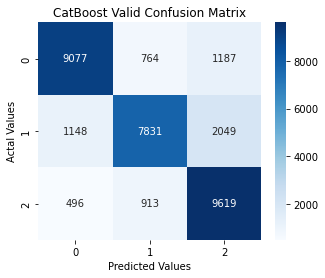

In [30]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cat_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [31]:
cat_cm_normalize = confusion_matrix(y,cat_pred, normalize='true')

cat_normalize_cm_df = pd.DataFrame(cat_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

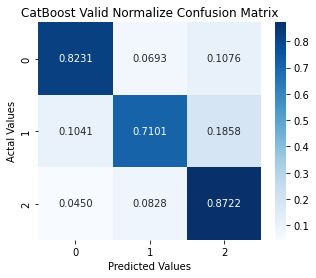

In [32]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(cat_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('CatBoost Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2) Test data 평가**

In [33]:
# Test Score
cat_pred_test = model_cat.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, cat_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, cat_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, cat_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, cat_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, cat_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, cat_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, cat_pred_test, normalize='true'))


Test Accuracy Score: 0.678754
Test F1 Score:  0.515248
Test Log Loss: 0.777724

Test ROC_AUC_Score: 0.716196

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.41      0.22      0.29       888
         1.0       0.55      0.40      0.46      1762
         2.0       0.73      0.86      0.79      4796

    accuracy                           0.68      7446
   macro avg       0.56      0.50      0.52      7446
weighted avg       0.65      0.68      0.65      7446


Confusion_matrix - Test data
[[ 198  121  569]
 [ 102  711  949]
 [ 185  466 4145]]

Confusion_matrix_Normalize - Test data
[[0.22297297 0.13626126 0.64076577]
 [0.05788876 0.40351873 0.53859251]
 [0.03857381 0.0971643  0.86426188]]


### **Test Set Confusion Matrix 시각화**

In [34]:
cat_cm_test = confusion_matrix(y_test,cat_pred_test)

cat_cm_test_df = pd.DataFrame(cat_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

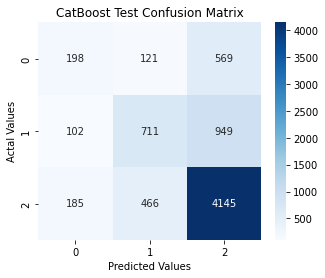

In [35]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cat_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
cat_cm_test_normalize = confusion_matrix(y_test, cat_pred_test, normalize='true')

cat_normalize_cm_test_df = pd.DataFrame(cat_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

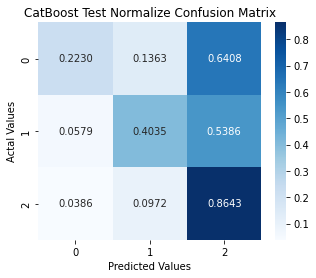

In [37]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(cat_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('CatBoost Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **Feature Importance**

In [38]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

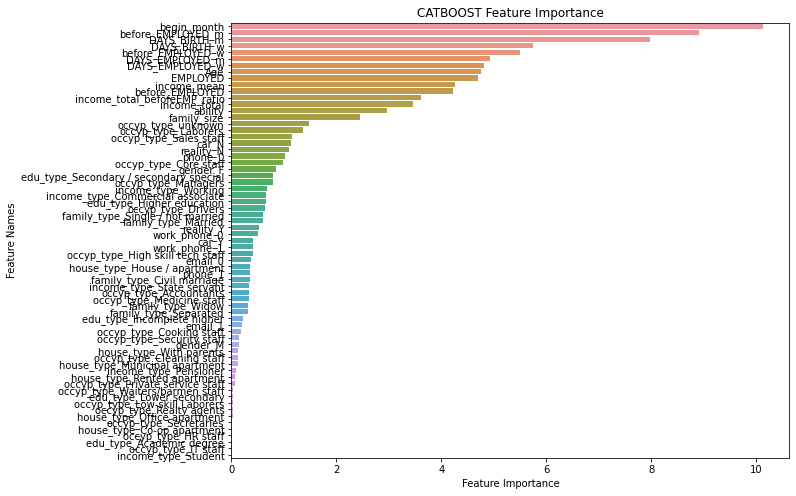

In [39]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## 2. model - KNN

In [40]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

knn_pred = np.zeros((X.shape[0], ))
knn_pred_test = np.zeros((X_test.shape[0], ))

knn_pred_proba = np.zeros((X.shape[0], n_class))
knn_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
  knn.fit(X_train, y_train)

  knn_pred[valid_idx] = knn.predict(X_valid)

  knn_pred_proba[valid_idx] = knn.predict_proba(X_valid)
  knn_pred_proba_test += knn.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, knn_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, knn_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 2.570811

----------------- Fold 1 -----------------

CV Log Loss Score: 2.624709

----------------- Fold 2 -----------------

CV Log Loss Score: 2.480671

----------------- Fold 3 -----------------

CV Log Loss Score: 2.594386

----------------- Fold 4 -----------------

CV Log Loss Score: 2.697675

Log Loss: 2.593647


## **Model(KNN) 평가**

### **1) Valid data 평가**

In [41]:
# Valid Score

print(f'Valid Accuracy Score: {accuracy_score(y, knn_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, knn_pred, average='macro'):.6f}")
print(f'\nValid Log Loss: {log_loss(y, knn_pred_proba):.6f}')
print(f"\nValid Roc_Auc_Score: {roc_auc_score(y, knn_pred_proba, multi_class='ovo'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, knn_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, knn_pred))

print('\nConfusion_matrix_normalize - valid data')
print(confusion_matrix(y, knn_pred, normalize='true'))

Valid Accuracy Score: 0.714031
Valid F1 Score:  0.694721

Valid Log Loss: 2.593647

Valid Roc_Auc_Score: 0.885250

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80     11028
         1.0       0.69      0.81      0.75     11028
         2.0       0.79      0.41      0.54     11028

    accuracy                           0.71     33084
   macro avg       0.73      0.71      0.69     33084
weighted avg       0.73      0.71      0.69     33084


Confusion_matrix - valid data
[[10129   556   343]
 [ 1209  8985   834]
 [ 3103  3416  4509]]

Confusion_matrix_normalize - valid data
[[0.91848023 0.05041712 0.03110265]
 [0.10963003 0.81474429 0.07562568]
 [0.28137468 0.30975698 0.40886834]]


### **Validation Set Confusion Matrix 시각화**

In [42]:
knn_cm = confusion_matrix(y,knn_pred)

knn_cm_df = pd.DataFrame(knn_cm, index = ['0','1','2'], columns = ['0','1','2'])

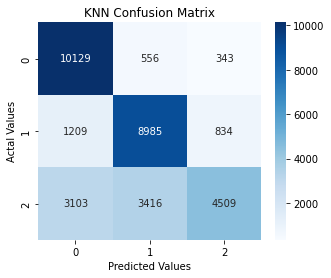

In [43]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(knn_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [44]:
knn_cm_normalize = confusion_matrix(y,knn_pred, normalize='true')

knn_normalize_cm_df = pd.DataFrame(knn_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

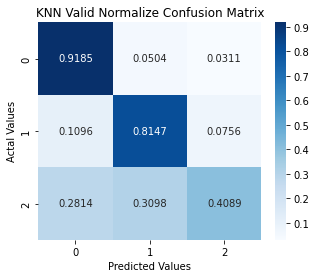

In [45]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(knn_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('KNN Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2) Test data 평가**

In [46]:
# Test Score
knn_pred_test = knn.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, knn_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, knn_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, knn_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, knn_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, knn_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, knn_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, knn_pred_test, normalize='true'))


Test Accuracy Score: 0.442519
Test F1 Score:  0.407233
Test Log Loss: 4.391369

Test ROC_AUC_Score: 0.649039

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.20      0.49      0.28       888
         1.0       0.34      0.51      0.41      1762
         2.0       0.75      0.41      0.53      4796

    accuracy                           0.44      7446
   macro avg       0.43      0.47      0.41      7446
weighted avg       0.59      0.44      0.47      7446


Confusion_matrix - Test data
[[ 438  231  219]
 [ 431  902  429]
 [1349 1492 1955]]

Confusion_matrix_Normalize - Test data
[[0.49324324 0.26013514 0.24662162]
 [0.2446084  0.51191827 0.24347333]
 [0.28127606 0.31109258 0.40763136]]


### **Test Set Confusion Matrix 시각화**

In [47]:
knn_cm_test = confusion_matrix(y_test,knn_pred_test)

knn_cm_test_df = pd.DataFrame(knn_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

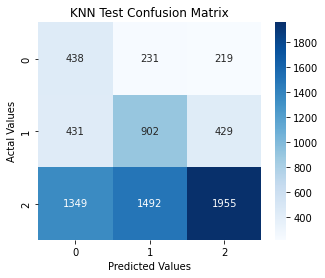

In [48]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(knn_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [49]:
knn_cm_test_normalize = confusion_matrix(y_test, knn_pred_test, normalize='true')

knn_normalize_cm_test_df = pd.DataFrame(knn_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

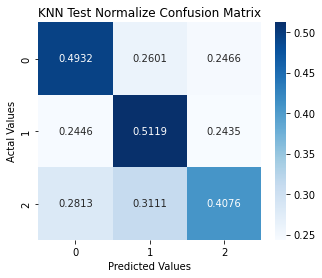

In [50]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(knn_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('KNN Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **3. Modeling - LightGBM**

In [51]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))


lgbm_pred = np.zeros((X.shape[0], ))
lgbm_pred_test = np.zeros((X_test.shape[0], ))

lgbm_pred_proba = np.zeros((X.shape[0], n_class))
lgbm_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  lgbm_model = LGBMClassifier(n_estimators=n_est, random_state= seed, objective= 'multi:softmax')
  lgbm_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=100)

  lgbm_pred[valid_idx] = lgbm_model.predict(X_valid)

  lgbm_pred_proba[valid_idx] = lgbm_model.predict_proba(X_valid)
  lgbm_pred_proba_test += lgbm_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, lgbm_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, lgbm_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

[100]	valid_0's multi_logloss: 0.667466
[200]	valid_0's multi_logloss: 0.59532
[300]	valid_0's multi_logloss: 0.556832
[400]	valid_0's multi_logloss: 0.539269
[500]	valid_0's multi_logloss: 0.52948
[600]	valid_0's multi_logloss: 0.522307
[700]	valid_0's multi_logloss: 0.517757
[800]	valid_0's multi_logloss: 0.517796
CV Log Loss Score: 0.517026

----------------- Fold 1 -----------------

[100]	valid_0's multi_logloss: 0.667915
[200]	valid_0's multi_logloss: 0.597858
[300]	valid_0's multi_logloss: 0.56244
[400]	valid_0's multi_logloss: 0.54258
[500]	valid_0's multi_logloss: 0.527626
[600]	valid_0's multi_logloss: 0.520265
[700]	valid_0's multi_logloss: 0.516348
[800]	valid_0's multi_logloss: 0.516037
[900]	valid_0's multi_logloss: 0.516484
CV Log Loss Score: 0.515684

----------------- Fold 2 -----------------

[100]	valid_0's multi_logloss: 0.665854
[200]	valid_0's multi_logloss: 0.597275
[300]	valid_0's multi_logloss: 0.559734
[400]	valid_0

## **Model(LightGBM) 평가**

### **1. Valid data 평가**

In [52]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, lgbm_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, lgbm_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, lgbm_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, lgbm_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, lgbm_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, lgbm_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, lgbm_pred, normalize='true'))


Valid Accuracy Score: 0.809062
Valid F1 Score:  0.808793
Valid Log Loss: 0.510125

Valid ROC_AUC_Score: 0.921998

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85     11028
         1.0       0.83      0.73      0.78     11028
         2.0       0.75      0.86      0.80     11028

    accuracy                           0.81     33084
   macro avg       0.81      0.81      0.81     33084
weighted avg       0.81      0.81      0.81     33084


Confusion_matrix - valid data
[[9213  660 1155]
 [ 975 8076 1977]
 [ 540 1010 9478]]

Confusion_matrix_Normalize - valid data
[[0.83541893 0.05984766 0.10473341]
 [0.08841132 0.73231774 0.17927095]
 [0.04896627 0.09158506 0.85944868]]


### **Validation Set Confusion Matrix 시각화**

In [53]:
lgbm_cm = confusion_matrix(y,lgbm_pred)

lgbm_cm_df = pd.DataFrame(lgbm_cm, index = ['0','1','2'], columns = ['0','1','2'])

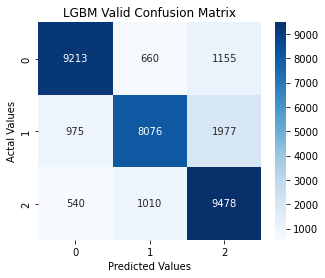

In [54]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(lgbm_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('LGBM Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [55]:
lgbm_cm_normalize = confusion_matrix(y,lgbm_pred, normalize='true')

lgbm_normalize_cm_df = pd.DataFrame(lgbm_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

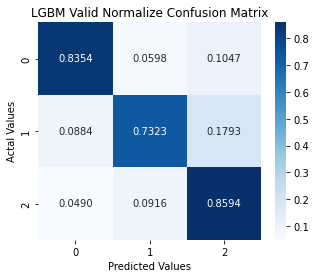

In [56]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(lgbm_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('LGBM Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [57]:
# Test Score
lgbm_pred_test = lgbm_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, lgbm_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, lgbm_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, lgbm_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, lgbm_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, lgbm_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, lgbm_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, lgbm_pred_test, normalize='true'))


Test Accuracy Score: 0.679425
Test F1 Score:  0.523226
Test Log Loss: 0.801311

Test ROC_AUC_Score: 0.721552

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.39      0.24      0.30       888
         1.0       0.55      0.42      0.48      1762
         2.0       0.74      0.86      0.79      4796

    accuracy                           0.68      7446
   macro avg       0.56      0.51      0.52      7446
weighted avg       0.65      0.68      0.66      7446


Confusion_matrix - Test data
[[ 214  125  549]
 [ 108  742  912]
 [ 222  471 4103]]

Confusion_matrix_Normalize - Test data
[[0.24099099 0.14076577 0.61824324]
 [0.06129398 0.42111237 0.51759364]
 [0.04628857 0.09820684 0.85550459]]


### **Test Set Confusion Matrix 시각화**

In [58]:
lgbm_cm_test = confusion_matrix(y_test,lgbm_pred_test)

lgbm_cm_test_df = pd.DataFrame(lgbm_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

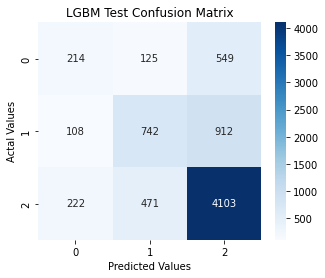

In [59]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(lgbm_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('LGBM Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [60]:
lgbm_cm_test_normalize = confusion_matrix(y_test, lgbm_pred_test, normalize='true')

lgbm_normalize_cm_test_df = pd.DataFrame(lgbm_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

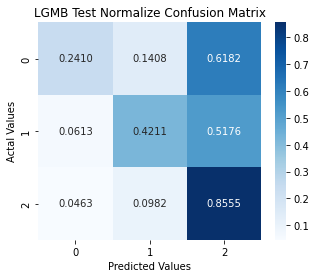

In [61]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(lgbm_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('LGMB Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **4. Modeling - LogisticRegression**

In [62]:
from sklearn.metrics import classification_report

skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))


lr_pred = np.zeros((X.shape[0], ))
lr_pred_test = np.zeros((X_test.shape[0], ))

lr_pred_proba = np.zeros((X.shape[0], n_class))
lr_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  lr = LogisticRegression(C=0.001, multi_class='multinomial', random_state=seed)
  lr.fit(X_train, y_train)

  lr_pred[valid_idx] = lr.predict(X_valid)

  lr_pred_proba[valid_idx] = lr.predict_proba(X_valid)
  lr_pred_proba_test += lr.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, lr_pred_proba[valid_idx]):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 1.055455

----------------- Fold 1 -----------------

CV Log Loss Score: 1.048464

----------------- Fold 2 -----------------

CV Log Loss Score: 1.047155

----------------- Fold 3 -----------------

CV Log Loss Score: 1.051877

----------------- Fold 4 -----------------

CV Log Loss Score: 1.053882


## **Model(LogisticRegression) 평가**


### **1. Valid data 평가**

In [63]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, lr_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, lr_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, lr_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, lr_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, lr_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, lr_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, lr_pred, normalize='true'))


Valid Accuracy Score: 0.455205
Valid F1 Score:  0.450663
Valid Log Loss: 1.051366

Valid ROC_AUC_Score: 0.640787

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.46      0.33      0.39     11028
         1.0       0.43      0.49      0.46     11028
         2.0       0.48      0.54      0.51     11028

    accuracy                           0.46     33084
   macro avg       0.46      0.46      0.45     33084
weighted avg       0.46      0.46      0.45     33084


Confusion_matrix - valid data
[[3658 4015 3355]
 [2412 5392 3224]
 [1820 3198 6010]]

Confusion_matrix_Normalize - valid data
[[0.33170112 0.36407327 0.30422561]
 [0.218716   0.48893725 0.29234675]
 [0.16503446 0.28998912 0.54497642]]


### **Validation Set Confusion Matrix 시각화**

In [64]:
lr_cm = confusion_matrix(y,lr_pred)

lr_cm_df = pd.DataFrame(lr_cm, index = ['0','1','2'], columns = ['0','1','2'])

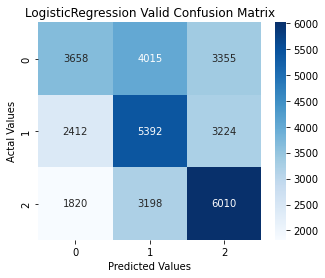

In [65]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(lr_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('LogisticRegression Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [66]:
lr_cm_normalize = confusion_matrix(y,lr_pred, normalize='true')

lr_normalize_cm_df = pd.DataFrame(lr_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

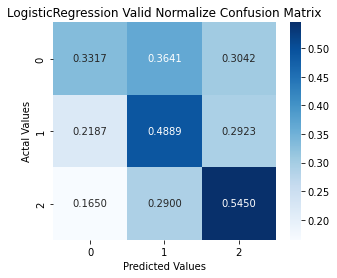

In [67]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(lr_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('LogisticRegression Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [68]:
# Test Score
lr_pred_test = lr.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, lr_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, lr_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, lr_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, lr_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, lr_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, lr_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, lr_pred_test, normalize='true'))


Test Accuracy Score: 0.496642
Test F1 Score:  0.395774
Test Log Loss: 1.049266

Test ROC_AUC_Score: 0.582465

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.15      0.19      0.17       888
         1.0       0.33      0.48      0.39      1762
         2.0       0.71      0.56      0.62      4796

    accuracy                           0.50      7446
   macro avg       0.40      0.41      0.40      7446
weighted avg       0.55      0.50      0.52      7446


Confusion_matrix - Test data
[[ 169  306  413]
 [ 222  848  692]
 [ 724 1391 2681]]

Confusion_matrix_Normalize - Test data
[[0.19031532 0.34459459 0.46509009]
 [0.12599319 0.48127128 0.39273553]
 [0.15095913 0.29003336 0.55900751]]


### **Test Set Confusion Matrix 시각화**

In [69]:
lr_cm_test = confusion_matrix(y_test,lr_pred_test)

lr_cm_test_df = pd.DataFrame(lr_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

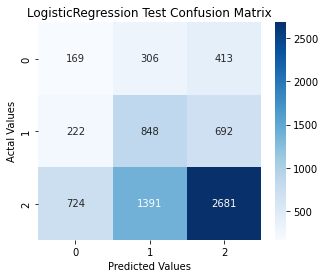

In [70]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(lr_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('LogisticRegression Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [71]:
lr_cm_test_normalize = confusion_matrix(y_test, lr_pred_test, normalize='true')

lr_normalize_cm_test_df = pd.DataFrame(lr_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

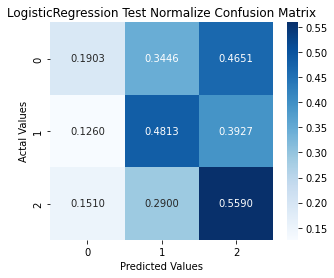

In [72]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(lr_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('LogisticRegression Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **5. Modeling - GaussianNB**

In [73]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

# lr_pred = np.zeros((X.shape[0], n_class))
# lr_pred_test = np.zeros((X_test.shape[0], n_class))
GNB_pred = np.zeros((X.shape[0], ))
GNB_pred_test = np.zeros((X_test.shape[0], ))

GNB_pred_proba = np.zeros((X.shape[0], n_class))
GNB_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  GNB_model = GaussianNB()
  GNB_model.fit(X_train, y_train)

  GNB_pred[valid_idx] = GNB_model.predict(X_valid)

  GNB_pred_proba[valid_idx] = GNB_model.predict_proba(X_valid)
  GNB_pred_proba_test += GNB_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, GNB_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, GNB_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 9.159453

----------------- Fold 1 -----------------

CV Log Loss Score: 12.284870

----------------- Fold 2 -----------------

CV Log Loss Score: 8.887024

----------------- Fold 3 -----------------

CV Log Loss Score: 7.115484

----------------- Fold 4 -----------------

CV Log Loss Score: 8.552296

Log Loss: 9.199845


## **Model(GaussianNB) 평가**

### **1. Valid data 평가**

In [74]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, GNB_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, GNB_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, GNB_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, GNB_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, GNB_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, GNB_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, GNB_pred, normalize='true'))


Valid Accuracy Score: 0.384567
Valid F1 Score:  0.289933
Valid Log Loss: 9.199845

Valid ROC_AUC_Score: 0.595335

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.36      0.92      0.52     11028
         1.0       0.40      0.03      0.06     11028
         2.0       0.54      0.20      0.29     11028

    accuracy                           0.38     33084
   macro avg       0.44      0.38      0.29     33084
weighted avg       0.44      0.38      0.29     33084


Confusion_matrix - valid data
[[10185   155   688]
 [ 9537   362  1129]
 [ 8471   381  2176]]

Confusion_matrix_Normalize - valid data
[[0.92355822 0.01405513 0.06238665]
 [0.86479869 0.03282554 0.10237577]
 [0.76813565 0.03454842 0.19731592]]


### **Validation Set Confusion Matrix 시각화**

In [75]:
gnb_cm = confusion_matrix(y,GNB_pred)

gnb_cm_df = pd.DataFrame(gnb_cm, index = ['0','1','2'], columns = ['0','1','2'])

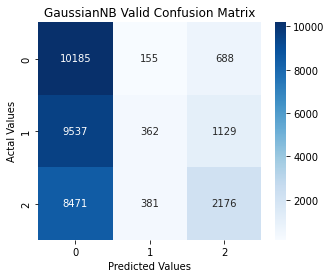

In [76]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(gnb_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('GaussianNB Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [77]:
gnb_cm_normalize = confusion_matrix(y,GNB_pred, normalize='true')

gnb_normalize_cm_df = pd.DataFrame(gnb_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

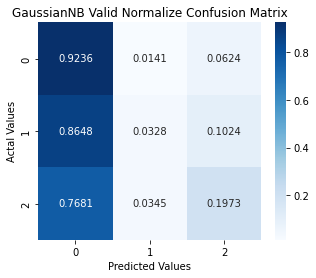

In [78]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(gnb_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('GaussianNB Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [79]:
# Test Score
GNB_pred_test = GNB_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, GNB_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, GNB_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, GNB_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, GNB_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, GNB_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, GNB_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, GNB_pred_test, normalize='true'))


Test Accuracy Score: 0.252485
Test F1 Score:  0.206575
Test Log Loss: 10.814627

Test ROC_AUC_Score: 0.519853

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.12      0.77      0.21       888
         1.0       0.41      0.03      0.06      1762
         2.0       0.67      0.24      0.35      4796

    accuracy                           0.25      7446
   macro avg       0.40      0.35      0.21      7446
weighted avg       0.54      0.25      0.26      7446


Confusion_matrix - Test data
[[ 687   15  186]
 [1329   55  378]
 [3595   63 1138]]

Confusion_matrix_Normalize - Test data
[[0.77364865 0.01689189 0.20945946]
 [0.75425653 0.03121453 0.21452894]
 [0.74958299 0.01313595 0.23728107]]


### **Test Set Confusion Matrix 시각화**

In [80]:
gnb_cm_test = confusion_matrix(y_test,GNB_pred_test)

gnb_cm_test_df = pd.DataFrame(gnb_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

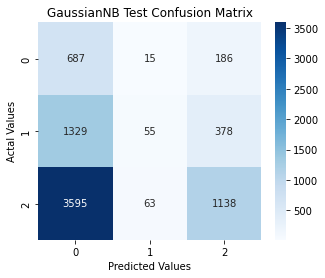

In [81]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(gnb_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('GaussianNB Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [82]:
gnb_cm_test_normalize = confusion_matrix(y_test, GNB_pred_test, normalize='true')

gnb_normalize_cm_test_df = pd.DataFrame(gnb_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

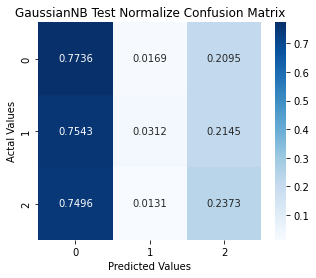

In [83]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(gnb_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('GaussianNB Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **6. Modeling - RandomforestClassifier**

In [84]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

rfc_pred = np.zeros((X.shape[0], ))
rfc_pred_test = np.zeros((X_test.shape[0], ))

rfc_pred_proba = np.zeros((X.shape[0], n_class))
rfc_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  rfc_model = RandomForestClassifier(n_estimators=n_est, random_state=seed)
  rfc_model.fit(X_train, y_train)

  rfc_pred[valid_idx] = rfc_model.predict(X_valid)

  rfc_pred_proba[valid_idx] = rfc_model.predict_proba(X_valid)
  rfc_pred_proba_test += rfc_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, rfc_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, rfc_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 0.630328

----------------- Fold 1 -----------------

CV Log Loss Score: 0.631102

----------------- Fold 2 -----------------

CV Log Loss Score: 0.625371

----------------- Fold 3 -----------------

CV Log Loss Score: 0.624084

----------------- Fold 4 -----------------

CV Log Loss Score: 0.625635

Log Loss: 0.627304


## **Model(RandomforestClassification) 평가**

### **1. Valid data 평가**

In [85]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, rfc_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, rfc_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, rfc_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, rfc_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, rfc_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, rfc_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, rfc_pred, normalize='true'))


Valid Accuracy Score: 0.796971
Valid F1 Score:  0.797224
Valid Log Loss: 0.627304

Valid ROC_AUC_Score: 0.902819

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85     11028
         1.0       0.79      0.77      0.78     11028
         2.0       0.75      0.79      0.77     11028

    accuracy                           0.80     33084
   macro avg       0.80      0.80      0.80     33084
weighted avg       0.80      0.80      0.80     33084


Confusion_matrix - valid data
[[9259  699 1070]
 [ 765 8443 1820]
 [ 843 1520 8665]]

Confusion_matrix_Normalize - valid data
[[0.83959013 0.06338411 0.09702575]
 [0.06936888 0.76559666 0.16503446]
 [0.07644178 0.13783098 0.78572724]]


### **Validation Set Confusion Matrix 시각화**

In [86]:
rfc_cm = confusion_matrix(y,rfc_pred)

rfc_cm_df = pd.DataFrame(rfc_cm, index = ['0','1','2'], columns = ['0','1','2'])

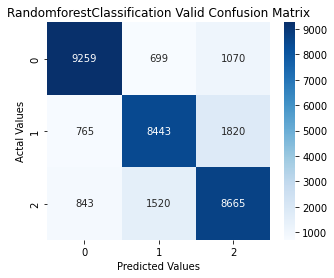

In [87]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(rfc_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('RandomforestClassification Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [88]:
rfc_cm_normalize = confusion_matrix(y,rfc_pred, normalize='true')

rfc_normalize_cm_df = pd.DataFrame(rfc_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

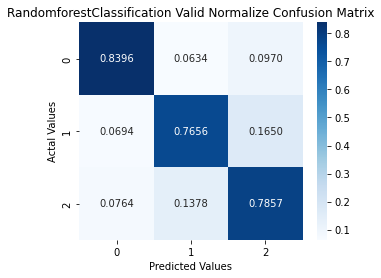

In [89]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(rfc_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('RandomforestClassification Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [90]:
# Test Score
rfc_pred_test = rfc_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, rfc_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, rfc_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, rfc_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, rfc_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, rfc_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, rfc_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, rfc_pred_test, normalize='true'))


Test Accuracy Score: 0.663578
Test F1 Score:  0.537664
Test Log Loss: 0.844298

Test ROC_AUC_Score: 0.722075

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.38      0.31      0.34       888
         1.0       0.51      0.48      0.49      1762
         2.0       0.76      0.79      0.78      4796

    accuracy                           0.66      7446
   macro avg       0.55      0.53      0.54      7446
weighted avg       0.65      0.66      0.66      7446


Confusion_matrix - Test data
[[ 277  168  443]
 [ 135  854  773]
 [ 318  668 3810]]

Confusion_matrix_Normalize - Test data
[[0.31193694 0.18918919 0.49887387]
 [0.07661748 0.4846765  0.43870602]
 [0.06630525 0.13928274 0.79441201]]


### **Test Set Confusion Matrix 시각화**

In [91]:
rfc_cm_test = confusion_matrix(y_test,rfc_pred_test)

rfc_cm_test_df = pd.DataFrame(rfc_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

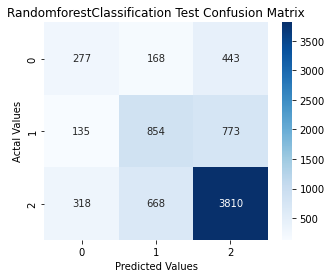

In [92]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(rfc_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('RandomforestClassification Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [93]:
rfc_cm_test_normalize = confusion_matrix(y_test, rfc_pred_test, normalize='true')

rfc_normalize_cm_test_df = pd.DataFrame(rfc_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

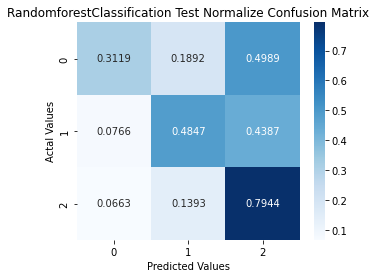

In [94]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(rfc_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('RandomforestClassification Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## 7. Model - XGBoost

In [95]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

xgb_pred = np.zeros((X.shape[0], ))
xgb_pred_test = np.zeros((X_test.shape[0], ))

xgb_pred_proba = np.zeros((X.shape[0], n_class))
xgb_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  xgb_model = xgb.XGBClassifier(n_estimators=n_est, random_state=seed, objective= 'multi:softmax')
  xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=100)

  xgb_pred[valid_idx] = xgb_model.predict(X_valid)

  xgb_pred_proba[valid_idx] = xgb_model.predict_proba(X_valid)
  xgb_pred_proba_test += xgb_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, xgb_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, xgb_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

[00:11:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.06422
[100]	validation_0-mlogloss:0.64856
[200]	validation_0-mlogloss:0.56809
[300]	validation_0-mlogloss:0.55114
[400]	validation_0-mlogloss:0.54975
[456]	validation_0-mlogloss:0.55296
CV Log Loss Score: 0.549311

----------------- Fold 1 -----------------

[00:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.06269
[100]	validation_0-mlogloss:0.62482
[200]	validation_0-mlogloss:0.56809
[300]	validation_0-mlogloss:0.55244
[400]	validation_0-m

## Model(XGBoost) 평가

## 1. Valid data 평가

In [96]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, xgb_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, xgb_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, xgb_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, xgb_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, xgb_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, xgb_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, xgb_pred, normalize='true'))


Valid Accuracy Score: 0.793586
Valid F1 Score:  0.792664
Valid Log Loss: 0.542047

Valid ROC_AUC_Score: 0.912976

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83     11028
         1.0       0.80      0.71      0.75     11028
         2.0       0.75      0.86      0.80     11028

    accuracy                           0.79     33084
   macro avg       0.80      0.79      0.79     33084
weighted avg       0.80      0.79      0.79     33084


Confusion_matrix - valid data
[[9009  873 1146]
 [1267 7786 1975]
 [ 521 1047 9460]]

Confusion_matrix_Normalize - valid data
[[0.81692057 0.07916213 0.1039173 ]
 [0.11488937 0.70602104 0.17908959]
 [0.04724338 0.09494015 0.85781647]]


### **Validation Set Confusion Matrix 시각화**

In [97]:
xgb_cm = confusion_matrix(y,xgb_pred)

xgb_cm_df = pd.DataFrame(xgb_cm, index = ['0','1','2'], columns = ['0','1','2'])

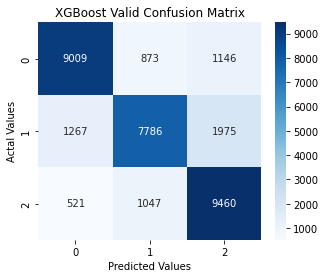

In [98]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(xgb_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Valid Confusion Matrix') 
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [99]:
xgb_cm_normalize = confusion_matrix(y,xgb_pred, normalize='true')

xgb_normalize_cm_df = pd.DataFrame(xgb_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

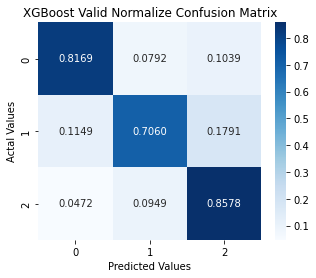

In [100]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(xgb_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('XGBoost Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [101]:
# Test Score
xgb_pred_test = xgb_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, xgb_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, xgb_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, xgb_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, xgb_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, xgb_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, xgb_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, xgb_pred_test, normalize='true'))


Test Accuracy Score: 0.677545
Test F1 Score:  0.522392
Test Log Loss: 0.795692

Test ROC_AUC_Score: 0.726986

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.41      0.25      0.31       888
         1.0       0.54      0.41      0.47      1762
         2.0       0.74      0.85      0.79      4796

    accuracy                           0.68      7446
   macro avg       0.56      0.51      0.52      7446
weighted avg       0.65      0.68      0.66      7446


Confusion_matrix - Test data
[[ 220  135  533]
 [ 111  728  923]
 [ 211  488 4097]]

Confusion_matrix_Normalize - Test data
[[0.24774775 0.15202703 0.60022523]
 [0.06299659 0.41316686 0.52383655]
 [0.043995   0.10175146 0.85425354]]


### **Test Set Confusion Matrix 시각화**

In [102]:
xgb_cm_test = confusion_matrix(y_test,xgb_pred_test)

xgb_cm_test_df = pd.DataFrame(xgb_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

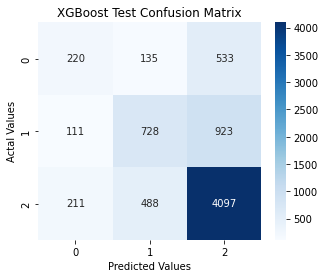

In [103]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(xgb_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [104]:
xgb_cm_test_normalize = confusion_matrix(y_test, xgb_pred_test, normalize='true')

xgb_normalize_cm_test_df = pd.DataFrame(xgb_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

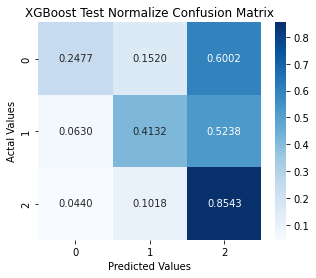

In [105]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(xgb_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('XGBoost Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## model - support vector machine

In [107]:
from sklearn.svm import SVC

In [108]:
# #Grid Search
# svc = SVC(class_weight='balanced')
# param = {'C':[0.1, 1, 10, 100],
#         'gamma':[1, 0.1, 0.01, 0.001, 0.00001, 10]}
# clf = GridSearchCV(svc,param,scoring='roc_auc',refit=True,cv=10)
# clf.fit(X_train_res,y_train_res)
# print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

# #Grid Search 결과 C = 0.1이 Best, gamma= 1 Best

In [148]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

svm_pred = np.zeros((X.shape[0], ))
svm_pred_test = np.zeros((X_test.shape[0], ))

svm_pred_proba = np.zeros((X.shape[0], n_class))
svm_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  svm_model = SVC(C = 0.1, kernel = 'rbf', gamma=1, random_state=seed, decision_function_shape='ovr', probability=True)
  svm_model.fit(X_train, y_train)

  svm_pred[valid_idx] = svm_model.predict(X_valid)

  svm_pred_proba[valid_idx] = svm_model.predict_proba(X_valid)
  svm_pred_proba_test += svm_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, svm_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, svm_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 0.817936

----------------- Fold 1 -----------------

CV Log Loss Score: 0.817366

----------------- Fold 2 -----------------

CV Log Loss Score: 0.838356

----------------- Fold 3 -----------------

CV Log Loss Score: 0.820234

----------------- Fold 4 -----------------

CV Log Loss Score: 0.810724

Log Loss: 0.820924


### 1) valid data

In [149]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, svm_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, svm_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, svm_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, svm_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, svm_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, svm_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, svm_pred, normalize='true'))


Valid Accuracy Score: 0.422138
Valid F1 Score:  0.339994
Valid Log Loss: 0.820924

Valid ROC_AUC_Score: 0.876024

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.90      0.18      0.29     11028
         1.0       0.85      0.11      0.19     11028
         2.0       0.37      0.98      0.53     11028

    accuracy                           0.42     33084
   macro avg       0.70      0.42      0.34     33084
weighted avg       0.70      0.42      0.34     33084


Confusion_matrix - valid data
[[ 1936   124  8968]
 [  121  1192  9715]
 [   97    93 10838]]

Confusion_matrix_Normalize - valid data
[[0.17555314 0.01124411 0.81320276]
 [0.01097207 0.1080885  0.88093943]
 [0.00879579 0.00843308 0.98277113]]


In [150]:
svm_cm = confusion_matrix(y,svm_pred)

svm_cm_df = pd.DataFrame(svm_cm, index = ['0','1','2'], columns = ['0','1','2'])

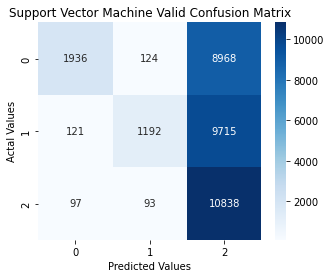

In [151]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(svm_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Support Vector Machine Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [152]:
svm_cm_normalize = confusion_matrix(y,svm_pred, normalize='true')

svm_normalize_cm_df = pd.DataFrame(svm_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

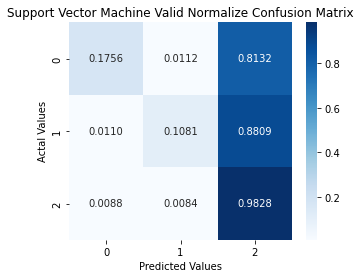

In [153]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(svm_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('Support Vector Machine Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### 2) test data

In [154]:
# Test Score
svm_pred_test = svm_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, svm_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, svm_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, svm_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, svm_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, svm_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, svm_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, svm_pred_test, normalize='true'))


Test Accuracy Score: 0.649073
Test F1 Score:  0.320905
Test Log Loss: 0.941965

Test ROC_AUC_Score: 0.655852

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.44      0.06      0.10       888
         1.0       0.57      0.04      0.07      1762
         2.0       0.65      0.98      0.79      4796

    accuracy                           0.65      7446
   macro avg       0.55      0.36      0.32      7446
weighted avg       0.61      0.65      0.54      7446


Confusion_matrix - Test data
[[  52   11  825]
 [  24   70 1668]
 [  43   42 4711]]

Confusion_matrix_Normalize - Test data
[[0.05855856 0.01238739 0.92905405]
 [0.01362089 0.03972758 0.94665153]
 [0.0089658  0.0087573  0.9822769 ]]


In [155]:
svm_cm_test = confusion_matrix(y_test,svm_pred_test)

svm_cm_test_df = pd.DataFrame(svm_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

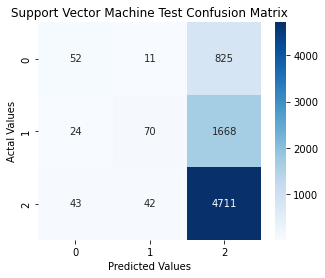

In [156]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(svm_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('Support Vector Machine Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [157]:
svm_cm_test_normalize = confusion_matrix(y_test, svm_pred_test, normalize='true')

svm_normalize_cm_test_df = pd.DataFrame(svm_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

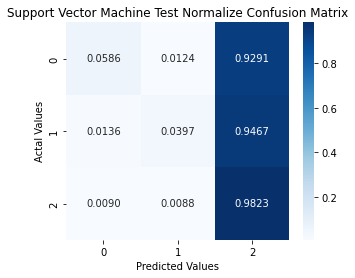

In [158]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(svm_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('Support Vector Machine Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## model - Decision Tree

In [121]:
from sklearn.tree import DecisionTreeClassifier

In [122]:
skfold = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X,y) :
  folds.append((train_idx, valid_idx))

dt_pred = np.zeros((X.shape[0], ))
dt_pred_test = np.zeros((X_test.shape[0], ))

dt_pred_proba = np.zeros((X.shape[0], n_class))
dt_pred_proba_test = np.zeros((X_test.shape[0], n_class))

for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  dt_model = DecisionTreeClassifier(random_state=seed, criterion='entropy')
  dt_model.fit(X_train, y_train)

  dt_pred[valid_idx] = dt_model.predict(X_valid)

  dt_pred_proba[valid_idx] = dt_model.predict_proba(X_valid)
  dt_pred_proba_test += dt_model.predict_proba(X_test) / n_fold

  # Log Loss
  print(f'CV Log Loss Score: {log_loss(y_valid, dt_pred_proba[valid_idx]):.6f}')
  time.sleep(1)

print(f'\nLog Loss: {log_loss(y, dt_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

CV Log Loss Score: 12.026799

----------------- Fold 1 -----------------

CV Log Loss Score: 11.801366

----------------- Fold 2 -----------------

CV Log Loss Score: 11.728875

----------------- Fold 3 -----------------

CV Log Loss Score: 10.936196

----------------- Fold 4 -----------------

CV Log Loss Score: 11.774114

Log Loss: 11.653466


### 1. valid data

In [123]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, dt_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, dt_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, dt_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, dt_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, dt_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, dt_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, dt_pred, normalize='true'))


Valid Accuracy Score: 0.657690
Valid F1 Score:  0.657597
Valid Log Loss: 11.653466

Valid ROC_AUC_Score: 0.745790

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     11028
         1.0       0.62      0.62      0.62     11028
         2.0       0.68      0.65      0.66     11028

    accuracy                           0.66     33084
   macro avg       0.66      0.66      0.66     33084
weighted avg       0.66      0.66      0.66     33084


Confusion_matrix - valid data
[[7733 1953 1342]
 [2074 6881 2073]
 [1589 2294 7145]]

Confusion_matrix_Normalize - valid data
[[0.70121509 0.17709467 0.12169024]
 [0.18806674 0.6239572  0.18797606]
 [0.14408778 0.20801596 0.64789626]]


In [124]:
dt_cm = confusion_matrix(y,dt_pred)

dt_cm_df = pd.DataFrame(dt_cm, index = ['0','1','2'], columns = ['0','1','2'])

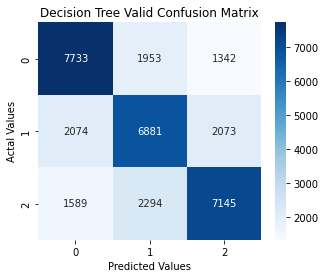

In [125]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(dt_cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [126]:
dt_cm_normalize = confusion_matrix(y,dt_pred, normalize='true')

dt_normalize_cm_df = pd.DataFrame(dt_cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

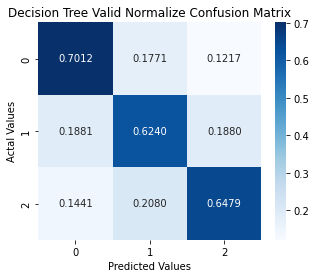

In [127]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(dt_normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('Decision Tree Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### train data

In [128]:
# Test Score
dt_pred_test = dt_model.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, dt_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, dt_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, dt_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, dt_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, dt_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, dt_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, dt_pred_test, normalize='true'))


Test Accuracy Score: 0.569299
Test F1 Score:  0.465594
Test Log Loss: 5.174054

Test ROC_AUC_Score: 0.677588

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.25      0.34      0.29       888
         1.0       0.39      0.43      0.41      1762
         2.0       0.74      0.66      0.70      4796

    accuracy                           0.57      7446
   macro avg       0.46      0.48      0.47      7446
weighted avg       0.60      0.57      0.58      7446


Confusion_matrix - Test data
[[ 298  183  407]
 [ 269  764  729]
 [ 623  996 3177]]

Confusion_matrix_Normalize - Test data
[[0.33558559 0.20608108 0.45833333]
 [0.15266742 0.43359818 0.41373439]
 [0.12989992 0.20767306 0.66242702]]


In [129]:
dt_cm_test = confusion_matrix(y_test,dt_pred_test)

dt_cm_test_df = pd.DataFrame(dt_cm_test, index = ['0','1','2'], columns = ['0','1','2'])

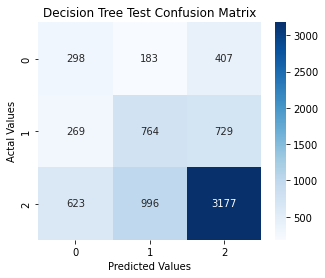

In [130]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(dt_cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [131]:
dt_cm_test_normalize = confusion_matrix(y_test, dt_pred_test, normalize='true')

dt_normalize_cm_test_df = pd.DataFrame(dt_cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

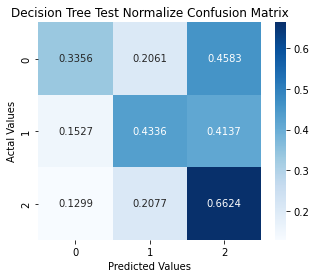

In [159]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(dt_normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('Decision Tree Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [236]:
algo_name=['Logistic','Naive Bayes','KNN','SVM','Decision Tree','XGBoost',
           'LightGBM','CatBoost']

### Valid Score

In [237]:
lr_valid_accuracy_score = accuracy_score(y, lr_pred)
GNB_valid_accuracy_score = accuracy_score(y, GNB_pred)
knn_valid_accuracy_score = accuracy_score(y, knn_pred)
svm_valid_accuracy_score = accuracy_score(y, svm_pred)
dt_valid_accuracy_score = accuracy_score(y, dt_pred)
xgb_valid_accuracy_score = accuracy_score(y, xgb_pred)
lgbm_valid_accuracy_score = accuracy_score(y, lgbm_pred)
# rfc_valid_accuracy_score = accuracy_score(y, rfc_pred)
cat_valid_accuracy_score = accuracy_score(y, cat_pred)

algo_valid_accuracy_score = [lr_valid_accuracy_score,
                             GNB_valid_accuracy_score,
                             knn_valid_accuracy_score,
                             svm_valid_accuracy_score,
                             dt_valid_accuracy_score,
                             xgb_valid_accuracy_score,
                             lgbm_valid_accuracy_score,
#                              rfc_valid_accuracy_score,
                             cat_valid_accuracy_score]

algo_valid_accuracy_1 = [round(i,6) for i in algo_valid_accuracy_score]

In [238]:
lr_valid_f1_score = f1_score(y, lr_pred, average='macro')
GNB_valid_f1_score = f1_score(y, GNB_pred, average='macro')
knn_valid_f1_score = f1_score(y, knn_pred, average='macro')
svm_valid_f1_score = f1_score(y, rfc_pred, average='macro')
dt_valid_f1_score = f1_score(y, dt_pred, average='macro')
xgb_valid_f1_score = f1_score(y, xgb_pred, average='macro')
lgbm_valid_f1_score = f1_score(y, lgbm_pred, average='macro')
# rfc_valid_f1_score = f1_score(y, rfc_pred, average='macro')
cat_valid_f1_score = f1_score(y, cat_pred, average='macro')

algo_valid_f1_score = [lr_valid_f1_score,
                       GNB_valid_f1_score,
                       knn_valid_f1_score,
                       svm_valid_f1_score,
                       dt_valid_f1_score,
                       xgb_valid_f1_score,
                       lgbm_valid_f1_score,
#                        rfc_valid_f1_score,
                      cat_valid_f1_score]

algo_valid_f1_score_1 = [round(i,6) for i in algo_valid_f1_score]

In [239]:
dt_valid_Log_Loss

11.653466180498423

In [240]:
lr_valid_Log_Loss = log_loss(y, lr_pred_proba)
GNB_valid_Log_Loss = log_loss(y, GNB_pred_proba)
knn_valid_Log_Loss = log_loss(y, knn_pred_proba)
svm_valid_Log_Loss = log_loss(y, svm_pred_proba)
dt_valid_Log_Loss = log_loss(y, dt_pred_proba)
xgb_valid_Log_Loss = log_loss(y, xgb_pred_proba)
lgbm_valid_Log_Loss = log_loss(y, lgbm_pred_proba)
# rfc_valid_Log_Loss = log_loss(y, rfc_pred_proba)
cat_valid_Log_Loss = log_loss(y, cat_pred_proba)

algo_valid_Log_Loss = [lr_valid_Log_Loss,
                       GNB_valid_Log_Loss,
                       knn_valid_Log_Loss,
                       svm_valid_Log_Loss,
                       dt_valid_Log_Loss,
                       xgb_valid_Log_Loss,
                       lgbm_valid_Log_Loss,
#                        rfc_valid_Log_Loss,
                       cat_valid_Log_Loss]

algo_valid_Log_Loss_1 = [round(i,6) for i in algo_valid_Log_Loss]

In [241]:
lr_valid_roc_auc_score = roc_auc_score(y, lr_pred_proba, multi_class='ovr')
GNB_valid_roc_auc_score = roc_auc_score(y, GNB_pred_proba, multi_class='ovr')
knn_valid_roc_auc_score = roc_auc_score(y, knn_pred_proba, multi_class='ovr')
xgb_valid_roc_auc_score = roc_auc_score(y, xgb_pred_proba, multi_class='ovr')
svm_valid_roc_auc_score = roc_auc_score(y, svm_pred_proba, multi_class='ovr')
dt_valid_roc_auc_score = roc_auc_score(y, dt_pred_proba, multi_class='ovr')
lgbm_valid_roc_auc_score = roc_auc_score(y, lgbm_pred_proba, multi_class='ovr')
# rfc_valid_roc_auc_score = roc_auc_score(y, rfc_pred_proba, multi_class='ovr')
cat_valid_roc_auc_score = roc_auc_score(y, cat_pred_proba, multi_class='ovr')

algo_valid_roc_auc_score = [lr_valid_roc_auc_score,
                            GNB_valid_roc_auc_score,
                            knn_valid_roc_auc_score,
                            svm_valid_roc_auc_score,
                            dt_valid_roc_auc_score,
                            xgb_valid_roc_auc_score,
                            lgbm_valid_roc_auc_score,
#                             rfc_valid_roc_auc_score,
                           cat_valid_roc_auc_score]

algo_valid_roc_auc_score_1= [round(i,6) for i in algo_valid_roc_auc_score]

In [242]:
model_metrics_valid = pd.DataFrame({
    'Algorithm': algo_name,
    'accuracy score':algo_valid_accuracy_1,
    'F1 score' : algo_valid_f1_score_1,
    'Log Loss' : algo_valid_Log_Loss_1,
    'roc_auc_score' : algo_valid_roc_auc_score_1
})

In [243]:
print('\nsorter accuracy score')
display(model_metrics_valid.sort_values('accuracy score',ascending=False))
print('\nsorter f1 score')
display(model_metrics_valid.sort_values('F1 score',ascending=False))
print('\nsorter Log Loss score')
display(model_metrics_valid.sort_values('Log Loss',ascending=True))
print('\nsorter ruc_auc score')
display(model_metrics_valid.sort_values('roc_auc_score',ascending=False))


sorter accuracy score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.809062,0.808793,0.510125,0.921998
7,CatBoost,0.801808,0.800959,0.542547,0.916272
5,XGBoost,0.793586,0.792664,0.542047,0.912976
2,KNN,0.714031,0.694721,2.593647,0.885250
4,Decision Tree,0.657690,0.657597,11.653466,0.745790
0,Logistic,0.455205,0.450663,1.051366,0.640787
3,SVM,0.422138,0.797224,0.820924,0.876024
1,Naive Bayes,0.384567,0.289933,9.199845,0.595335



sorter f1 score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.809062,0.808793,0.510125,0.921998
7,CatBoost,0.801808,0.800959,0.542547,0.916272
3,SVM,0.422138,0.797224,0.820924,0.876024
5,XGBoost,0.793586,0.792664,0.542047,0.912976
2,KNN,0.714031,0.694721,2.593647,0.885250
4,Decision Tree,0.657690,0.657597,11.653466,0.745790
0,Logistic,0.455205,0.450663,1.051366,0.640787
1,Naive Bayes,0.384567,0.289933,9.199845,0.595335



sorter Log Loss score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.809062,0.808793,0.510125,0.921998
5,XGBoost,0.793586,0.792664,0.542047,0.912976
7,CatBoost,0.801808,0.800959,0.542547,0.916272
3,SVM,0.422138,0.797224,0.820924,0.876024
0,Logistic,0.455205,0.450663,1.051366,0.640787
2,KNN,0.714031,0.694721,2.593647,0.885250
1,Naive Bayes,0.384567,0.289933,9.199845,0.595335
4,Decision Tree,0.657690,0.657597,11.653466,0.745790



sorter ruc_auc score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.809062,0.808793,0.510125,0.921998
7,CatBoost,0.801808,0.800959,0.542547,0.916272
5,XGBoost,0.793586,0.792664,0.542047,0.912976
2,KNN,0.714031,0.694721,2.593647,0.885250
3,SVM,0.422138,0.797224,0.820924,0.876024
4,Decision Tree,0.657690,0.657597,11.653466,0.745790
0,Logistic,0.455205,0.450663,1.051366,0.640787
1,Naive Bayes,0.384567,0.289933,9.199845,0.595335


In [244]:
lr_valid_classification_report = classification_report(y,lr_pred)
GNB_valid_classification_report = classification_report(y, GNB_pred)
knn_valid_classification_report = classification_report(y, knn_pred)
svm_valid_classification_report = classification_report(y, svm_pred)
dt_valid_classification_report = classification_report(y, dt_pred)
xgb_valid_classification_report = classification_report(y, xgb_pred)
lgbm_valid_classification_report = classification_report(y, lgbm_pred)
# rfc_valid_classification_report = classification_report(y, rfc_pred)
cat_valid_classification_report = classification_report(y, cat_pred)

# algo_valid_classification_report = [lr_valid_classification_report,GNB_valid_classification_report,
#                            knn_valid_classification_report,xgb_valid_classification_report,
#                            lgbm_valid_classification_report,rfc_valid_classification_report,
#                            cat_valid_classification_report]

print("\nclassification report : Logistic")
print(lr_valid_classification_report)

print("\nclassification report : Naive Bayes")
print(GNB_valid_classification_report)

print("\nclassification report : KNN")
print(knn_valid_classification_report)

print("\nclassification report : SVM")
print(svm_valid_classification_report)

print("\nclassification report : Decision Tree")
print(dt_valid_classification_report)

print("\nclassification report : XGBoost")
print(xgb_valid_classification_report)

print("\nclassification report : LightGBM")
print(lgbm_valid_classification_report)

# print("\nclassification report : RandomForest")
# print(rfc_valid_classification_report)

print("\nclassification report : CatBoost")
print(cat_valid_classification_report)


classification report : Logistic
              precision    recall  f1-score   support

         0.0       0.46      0.33      0.39     11028
         1.0       0.43      0.49      0.46     11028
         2.0       0.48      0.54      0.51     11028

    accuracy                           0.46     33084
   macro avg       0.46      0.46      0.45     33084
weighted avg       0.46      0.46      0.45     33084


classification report : Naive Bayes
              precision    recall  f1-score   support

         0.0       0.36      0.92      0.52     11028
         1.0       0.40      0.03      0.06     11028
         2.0       0.54      0.20      0.29     11028

    accuracy                           0.38     33084
   macro avg       0.44      0.38      0.29     33084
weighted avg       0.44      0.38      0.29     33084


classification report : KNN
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80     11028
         1.0       0.69      

### test score

In [245]:
lr_test_accuracy_score = accuracy_score(y_test, lr_pred_test)
GNB_test_accuracy_score = accuracy_score(y_test, GNB_pred_test)
knn_test_accuracy_score = accuracy_score(y_test, knn_pred_test)
svm_test_accuracy_score = accuracy_score(y_test, svm_pred_test)
dt_test_accuracy_score = accuracy_score(y_test, dt_pred_test)
xgb_test_accuracy_score = accuracy_score(y_test, xgb_pred_test)
lgbm_test_accuracy_score = accuracy_score(y_test, lgbm_pred_test)
# rfc_test_accuracy_score = accuracy_score(y_test, rfc_pred_test)
cat_test_accuracy_score = accuracy_score(y_test, cat_pred_test)

algo_test_accuracy_score = [lr_test_accuracy_score,
                            GNB_test_accuracy_score,
                            knn_test_accuracy_score,
                            svm_test_accuracy_score,
                            dt_test_accuracy_score,
                            xgb_test_accuracy_score,
                            lgbm_test_accuracy_score,
#                             rfc_test_accuracy_score,
                            cat_test_accuracy_score]

algo_test_accuracy_1 = [round(i,6) for i in algo_test_accuracy_score]

In [246]:
lr_test_f1_score = f1_score(y_test, lr_pred_test, average='macro')
GNB_test_f1_score = f1_score(y_test, GNB_pred_test, average='macro')
knn_test_f1_score = f1_score(y_test, knn_pred_test, average='macro')
svm_test_f1_score = f1_score(y_test, svm_pred_test, average='macro')
dt_test_f1_score = f1_score(y_test, dt_pred_test, average='macro')
xgb_test_f1_score = f1_score(y_test, xgb_pred_test, average='macro')
lgbm_test_f1_score = f1_score(y_test, lgbm_pred_test, average='macro')
# rfc_test_f1_score = f1_score(y_test, rfc_pred_test, average='macro')
cat_test_f1_score = f1_score(y_test, cat_pred_test, average='macro')

algo_test_f1_score = [lr_test_f1_score,
                      GNB_test_f1_score,
                      knn_test_f1_score,
                      svm_test_f1_score,
                      dt_test_f1_score,
                      xgb_test_f1_score,
                      lgbm_test_f1_score,
#                       rfc_test_f1_score,
                      cat_test_f1_score]

algo_test_f1_score_1 = [round(i,6) for i in algo_test_f1_score]

In [247]:
lr_test_Log_Loss = log_loss(y_test, lr_pred_proba_test)
GNB_test_Log_Loss = log_loss(y_test, GNB_pred_proba_test)
knn_test_Log_Loss = log_loss(y_test, knn_pred_proba_test)
svm_test_Log_Loss = log_loss(y_test, svm_pred_proba_test)
dt_test_Log_Loss = log_loss(y_test, dt_pred_proba_test)
xgb_test_Log_Loss = log_loss(y_test, xgb_pred_proba_test)
lgbm_test_Log_Loss = log_loss(y_test, lgbm_pred_proba_test)
# rfc_test_Log_Loss = log_loss(y_test, rfc_pred_proba_test)
cat_test_Log_Loss = log_loss(y_test, cat_pred_proba_test)

algo_test_Log_Loss = [lr_test_Log_Loss,
                      GNB_test_Log_Loss,
                      knn_test_Log_Loss,
                      svm_test_Log_Loss,
                      dt_test_Log_Loss,
                      xgb_test_Log_Loss,
                      lgbm_test_Log_Loss,
#                       rfc_test_Log_Loss,
                      cat_test_Log_Loss]

algo_test_Log_Loss_1 = [round(i,6) for i in algo_test_Log_Loss]

In [248]:
lr_test_roc_auc_score = roc_auc_score(y_test, lr_pred_proba_test, multi_class='ovr')
GNB_test_roc_auc_score = roc_auc_score(y_test, GNB_pred_proba_test, multi_class='ovr')
knn_test_roc_auc_score = roc_auc_score(y_test, knn_pred_proba_test, multi_class='ovr')
svm_test_roc_auc_score = roc_auc_score(y_test, svm_pred_proba_test, multi_class='ovr')
dt_test_roc_auc_score = roc_auc_score(y_test, dt_pred_proba_test, multi_class='ovr')
xgb_test_roc_auc_score = roc_auc_score(y_test, xgb_pred_proba_test, multi_class='ovr')
lgbm_test_roc_auc_score = roc_auc_score(y_test, lgbm_pred_proba_test, multi_class='ovr')
# rfc_test_roc_auc_score = roc_auc_score(y_test, rfc_pred_proba_test, multi_class='ovr')
cat_test_roc_auc_score = roc_auc_score(y_test, cat_pred_proba_test, multi_class='ovr')

algo_test_roc_auc_score = [lr_test_roc_auc_score,
                           GNB_test_roc_auc_score,
                           knn_test_roc_auc_score,
                           svm_test_roc_auc_score,
                           dt_test_roc_auc_score,
                           xgb_test_roc_auc_score,
                           lgbm_test_roc_auc_score,
#                            rfc_test_roc_auc_score,
                           cat_test_roc_auc_score]

algo_test_roc_auc_score_1= [round(i,6) for i in algo_test_roc_auc_score]

In [249]:
model_metrics_test = pd.DataFrame({
    'Algorithm': algo_name,
    'accuracy score':algo_test_accuracy_1,
    'F1 score' : algo_test_f1_score_1,
    'Log Loss' : algo_test_Log_Loss_1,
    'roc_auc_score' : algo_test_roc_auc_score_1
})

In [250]:
print('\nsorter accuracy score')
display(model_metrics_test.sort_values('accuracy score',ascending=False))
print('\nsorter f1 score')
display(model_metrics_test.sort_values('F1 score',ascending=False))
print('\nsorter Log Loss score')
display(model_metrics_test.sort_values('Log Loss',ascending=True))
print('\nsorter ruc_auc score')
display(model_metrics_test.sort_values('roc_auc_score',ascending=False))


sorter accuracy score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.679425,0.523226,0.801311,0.721552
7,CatBoost,0.678754,0.515248,0.777724,0.716196
5,XGBoost,0.677545,0.522392,0.795692,0.726986
3,SVM,0.649073,0.320905,0.941965,0.655852
4,Decision Tree,0.569299,0.465594,5.174054,0.677588
0,Logistic,0.496642,0.395774,1.049266,0.582465
2,KNN,0.442519,0.407233,4.391369,0.649039
1,Naive Bayes,0.252485,0.206575,10.814627,0.519853



sorter f1 score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
6,LightGBM,0.679425,0.523226,0.801311,0.721552
5,XGBoost,0.677545,0.522392,0.795692,0.726986
7,CatBoost,0.678754,0.515248,0.777724,0.716196
4,Decision Tree,0.569299,0.465594,5.174054,0.677588
2,KNN,0.442519,0.407233,4.391369,0.649039
0,Logistic,0.496642,0.395774,1.049266,0.582465
3,SVM,0.649073,0.320905,0.941965,0.655852
1,Naive Bayes,0.252485,0.206575,10.814627,0.519853



sorter Log Loss score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
7,CatBoost,0.678754,0.515248,0.777724,0.716196
5,XGBoost,0.677545,0.522392,0.795692,0.726986
6,LightGBM,0.679425,0.523226,0.801311,0.721552
3,SVM,0.649073,0.320905,0.941965,0.655852
0,Logistic,0.496642,0.395774,1.049266,0.582465
2,KNN,0.442519,0.407233,4.391369,0.649039
4,Decision Tree,0.569299,0.465594,5.174054,0.677588
1,Naive Bayes,0.252485,0.206575,10.814627,0.519853



sorter ruc_auc score


,Algorithm,accuracy score,F1 score,Log Loss,roc_auc_score
5,XGBoost,0.677545,0.522392,0.795692,0.726986
6,LightGBM,0.679425,0.523226,0.801311,0.721552
7,CatBoost,0.678754,0.515248,0.777724,0.716196
4,Decision Tree,0.569299,0.465594,5.174054,0.677588
3,SVM,0.649073,0.320905,0.941965,0.655852
2,KNN,0.442519,0.407233,4.391369,0.649039
0,Logistic,0.496642,0.395774,1.049266,0.582465
1,Naive Bayes,0.252485,0.206575,10.814627,0.519853


In [251]:
lr_test_classification_report = classification_report(y_test,lr_pred_test)
GNB_test_classification_report = classification_report(y_test, GNB_pred_test)
knn_test_classification_report = classification_report(y_test, knn_pred_test)
svm_test_classification_report = classification_report(y_test, svm_pred_test)
dt_test_classification_report = classification_report(y_test, dt_pred_test)
xgb_test_classification_report = classification_report(y_test, xgb_pred_test)
lgbm_test_classification_report = classification_report(y_test, lgbm_pred_test)
# rfc_test_classification_report = classification_report(y_test, rfc_pred_test)
cat_test_classification_report = classification_report(y_test, cat_pred_test)

print("\nclassification report : Logistic")
print(lr_test_classification_report)

print("\nclassification report : Naive Bayes")
print(GNB_test_classification_report)

print("\nclassification report : KNN")
print(knn_test_classification_report)

print("\nclassification report : SVM")
print(svm_test_classification_report)

print("\nclassification report : Decision Tree")
print(dt_test_classification_report)

print("\nclassification report : XGBoost")
print(xgb_test_classification_report)

print("\nclassification report : LightGBM")
print(lgbm_test_classification_report)

# print("\nclassification report : RandomForest")
# print(rfc_test_classification_report)

print("\nclassification report : CatBoost")
print(cat_test_classification_report)




classification report : Logistic
              precision    recall  f1-score   support

         0.0       0.15      0.19      0.17       888
         1.0       0.33      0.48      0.39      1762
         2.0       0.71      0.56      0.62      4796

    accuracy                           0.50      7446
   macro avg       0.40      0.41      0.40      7446
weighted avg       0.55      0.50      0.52      7446


classification report : Naive Bayes
              precision    recall  f1-score   support

         0.0       0.12      0.77      0.21       888
         1.0       0.41      0.03      0.06      1762
         2.0       0.67      0.24      0.35      4796

    accuracy                           0.25      7446
   macro avg       0.40      0.35      0.21      7446
weighted avg       0.54      0.25      0.26      7446


classification report : KNN
              precision    recall  f1-score   support

         0.0       0.20      0.49      0.28       888
         1.0       0.34      